In [33]:
import datetime
import itertools
import pickle

import matplotlib.ticker
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

plt.style.use([{"figure.figsize": (9.6, 4)}])

LEVELS = ["NEW", "NOV", "INT", "ADV", "ALS", "CHMP"]
LEVEL_TO_RANK = {level: i for i, level in enumerate(LEVELS)}
LEVEL_TO_POINTS_THRESHOLD = {
    "NEW": 1,
    "NOV": 16,
    "INT": 30,
    "ADV": 60,
    "ALS": 150,
    "CHMP": 1e9,
}

YEAR_TO_MONTHS = 12

In [38]:
def column_sort_key(column_name):
    """Sort function for dataframe columns."""
    if column_name == "level":
        return -1
    level = column_name.split("_")[0]
    key = LEVEL_TO_RANK[level] * 2
    if "first_point_time" in column_name:
        return key
    elif "finish_time" in column_name:
        return key + 1
    else:
        raise ValueError(f"Invalid column name: {column_name}")


def column_to_display_name(column_name):
    """Converts dataframe column name to a human-readable label."""
    return column_name.replace("_", " ").replace(" time", "")


def to_date(date_str):
    """Convert a date string like "January 2020" to a datetime object."""
    return datetime.datetime.strptime(date_str, "%B %Y")


def get_months_between(date_1, date_2):
    """Get the number of months between two dates."""
    return (date_1.year - date_2.year) * 12 + date_1.month - date_2.month

In [23]:
# Load the data generated by scrape-data.py
data = pickle.load(open("data.pkl", "rb"))

In [24]:
# Parse the data

dancer_infos = []
for dancer in tqdm(data):
    main_role_info = dancer["dominate_data"]
    level = main_role_info["level"]["allowed"]
    if level not in LEVEL_TO_RANK:
        # Ignore level "PRO", e.g., dancer 5, as I don"t know how to categorize
        # it.
        continue
    rank = LEVEL_TO_RANK[level]
    placements = main_role_info["placements"]
    if isinstance(placements, list):
        # Ignore people who somehow have no placements, e.g., dancer 3. In this
        # case, `placements` is an empty list rather than a dict.
        continue
    placements = placements.get("West Coast Swing")
    if placements is None:
        continue

    dancer_info = {"id": dancer["dancer_wsdcid"], "level": level}
    for rank_i in range(rank + 1):
        level_i = LEVELS[rank_i]
        if level_i not in placements:
            continue
        level_results = placements[level_i]["competitions"]

        first_point_time = level_results[-1]["event"]["date"]
        finish_time = None
        cumulative_points = 0
        threshold = LEVEL_TO_POINTS_THRESHOLD[level_i]
        for result in level_results[::-1]:
            cumulative_points += result["points"]
            if cumulative_points >= threshold:
                finish_time = result["event"]["date"]
                break

        # Also check if they got out of this division by pointing in the
        # division above.
        if rank_i + 1 < len(LEVELS):
            next_level_results = placements.get(LEVELS[rank_i + 1])
            if next_level_results is not None:
                maybe_finish_time = next_level_results["competitions"][-1]["event"][
                    "date"
                ]
                if finish_time is None or to_date(maybe_finish_time) < to_date(
                    finish_time
                ):
                    finish_time = maybe_finish_time

        dancer_info[f"{level_i}_first_point_time"] = first_point_time
        if finish_time is not None and threshold > 1:
            dancer_info[f"{level_i}_finish_time"] = finish_time

    dancer_infos.append(dancer_info)

  0%|          | 0/22416 [00:00<?, ?it/s]

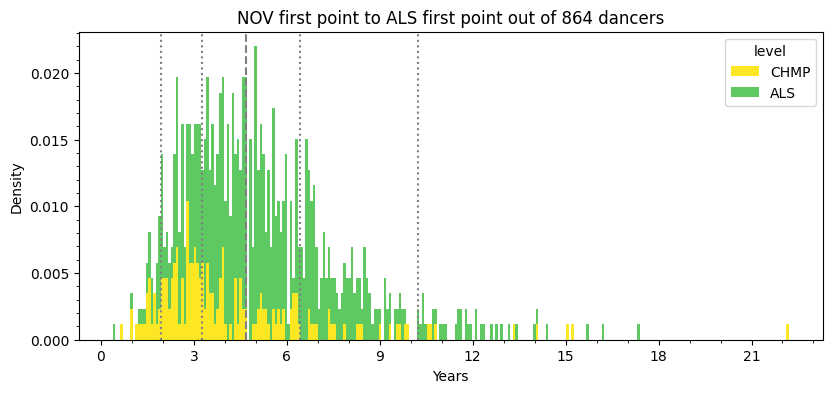

count   864.00
mean      5.16
std       2.64
min       0.42
1%        1.33
5%        1.93
10%       2.42
25%       3.25
50%       4.67
75%       6.44
90%       8.50
95%      10.25
99%      14.03
max      22.25
Name: diff, dtype: float64


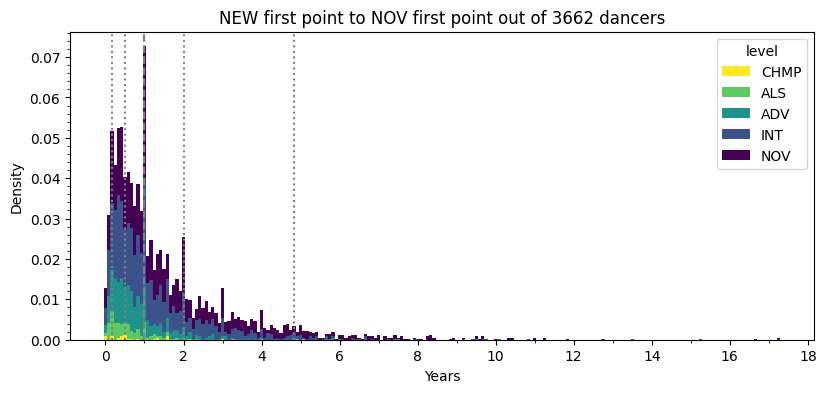

count   3662.00
mean       1.57
std        1.72
min        0.00
1%         0.00
5%         0.17
10%        0.25
25%        0.50
50%        1.00
75%        2.00
90%        3.67
95%        4.83
99%        8.33
max       17.33
Name: diff, dtype: float64


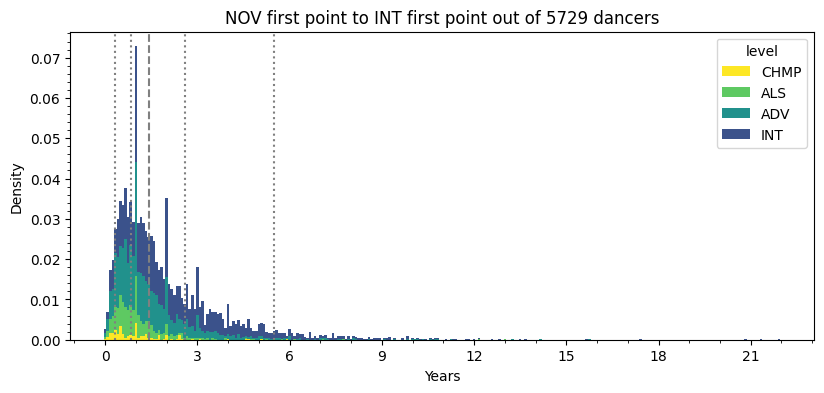

count   5729.00
mean       1.98
std        1.85
min        0.00
1%         0.17
5%         0.33
10%        0.42
25%        0.83
50%        1.42
75%        2.58
90%        4.17
95%        5.50
99%        9.14
max       22.00
Name: diff, dtype: float64


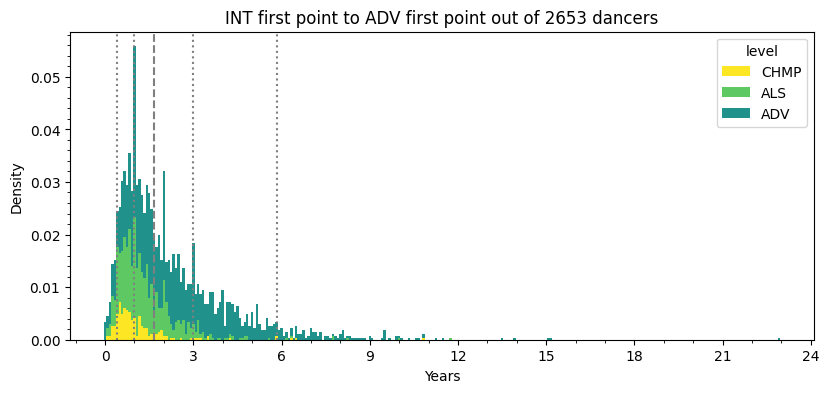

count   2653.00
mean       2.22
std        1.90
min        0.00
1%         0.17
5%         0.42
10%        0.58
25%        1.00
50%        1.67
75%        3.00
90%        4.58
95%        5.83
99%        9.04
max       23.00
Name: diff, dtype: float64


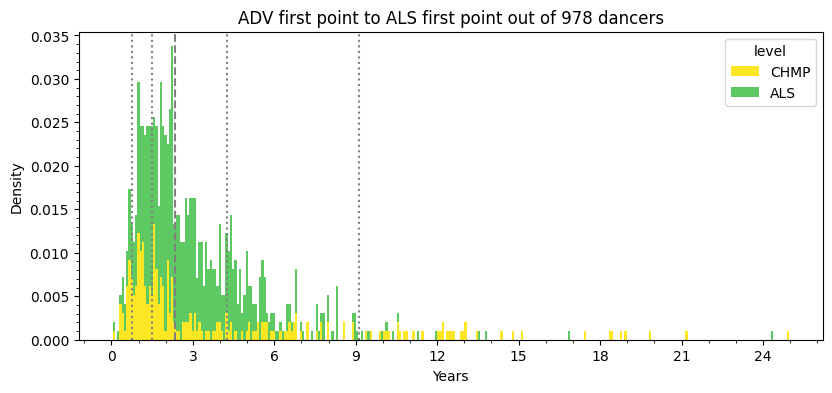

count   978.00
mean      3.37
std       3.05
min       0.08
1%        0.42
5%        0.75
10%       1.00
25%       1.50
50%       2.33
75%       4.25
90%       6.67
95%       9.11
99%      15.57
max      25.00
Name: diff, dtype: float64


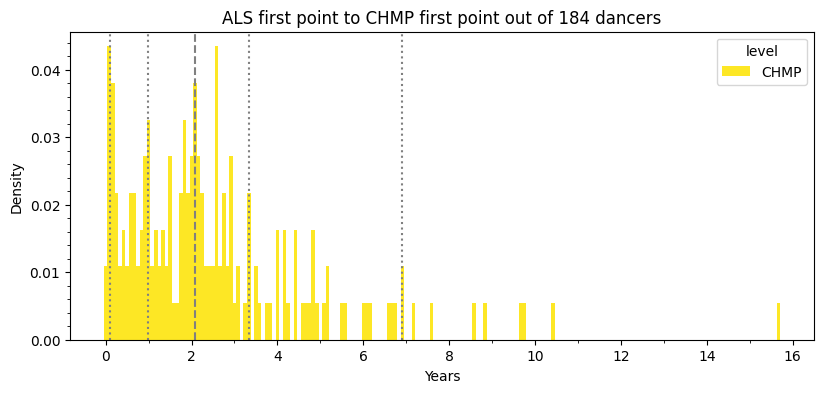

count   184.00
mean      2.55
std       2.30
min       0.00
1%        0.07
5%        0.10
10%       0.25
25%       0.98
50%       2.08
75%       3.33
90%       5.17
95%       6.89
99%       9.86
max      15.75
Name: diff, dtype: float64


In [39]:
# Plot the data

df = pd.DataFrame(dancer_infos).set_index("id")
df = df[sorted(df.columns, key=column_sort_key)]
date_columns = [col for col in df.columns if "time" in col]
for column in date_columns:
    df[column] = pd.to_datetime(df[column], format="%B %Y")


def plot(diffs):
    # Keep colors consistent across all plots
    num_colors = len(LEVELS) - 1  # no color for NEW
    cmap = plt.get_cmap("viridis", num_colors)
    custom_colors = [cmap(i) for i in range(num_colors)]
    level_colors = dict(zip(LEVELS[1:], custom_colors))

    legend_order = LEVELS[-1 : LEVEL_TO_RANK[level_2] - 1 : -1]
    diffs.pivot(columns="level")["diff"].reindex(columns=legend_order).plot(
        kind="hist",
        stacked=True,
        # Plot the density. kwarg `density=True` is an also an option
        weights=np.ones(len(diffs)) / len(diffs),
        bins=(diffs["diff"].max() * YEAR_TO_MONTHS).astype(int),
        align="left",
        title=f"{column_to_display_name(col_1)} to {column_to_display_name(col_2)} out of {len(diffs)} dancers",
        xlabel="Years",
        ylabel="Density",
        color=level_colors,
    )

    percentiles = diffs["diff"].describe(
        percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    )
    plt.axvline(x=percentiles["50%"], color="gray", linestyle="dashed")
    for percentile in ["5%", "25%", "75%", "95%"]:
        plt.axvline(x=percentiles[percentile], color="gray", linestyle="dotted")

    plt.minorticks_on()
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.gca().xaxis.set_minor_locator(
        matplotlib.ticker.MaxNLocator(nbins=30, integer=True)
    )
    # plt.savefig(f"{col_1}-{col_2}.png", bbox_inches="tight")
    plt.show()
    with pd.option_context("display.float_format", "{:0.2f}".format):
        print(percentiles)


for level_1, level_2 in [
    ("NOV", "ALS"),
    ("NEW", "NOV"),
    ("NOV", "INT"),
    ("INT", "ADV"),
    ("ADV", "ALS"),
    ("ALS", "CHMP"),
]:
    # Plot histogram of time between first level_1 point and first level_2 point.
    # Histogram is stacked by `level` column.
    col_1 = f"{level_1}_first_point_time"
    col_2 = f"{level_2}_first_point_time"
    # Create dataframe with only `level` column and the diff of the two relevant
    # columns
    diffs = df[["level", col_2, col_1]].copy()
    diffs["diff"] = diffs[col_2].dt.to_period("M") - diffs[col_1].dt.to_period("M")
    diffs["diff"] = (
        diffs[~diffs["diff"].isnull()]["diff"]
        .apply(lambda x: x.n / YEAR_TO_MONTHS)
        .astype(float)
    )
    diffs = diffs[diffs["diff"] >= 0]

    plot(diffs)